# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%env CUDA_VISIBLE_DEVICES=0
%env BLISS_HOME=/home/yppatel/bliss

Modules to reload:
all-except-skipped

Modules to skip:

env: CUDA_VISIBLE_DEVICES=0
env: BLISS_HOME=/home/yppatel/bliss


In [12]:
%matplotlib inline 

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.substructure.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

0


# Encoder blend images

In [5]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])

In [6]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

In [24]:
dataset.image_decoder.generate_residual = True
sample_batch_size = 16
tile_catalog = dataset.sample_prior(sample_batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
packed_images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)
images = packed_images["global"]
residuals = packed_images["subhalos"]

disk_frac=0.8520038723945618
disk_frac=0.09298723936080933
disk_frac=0.7704977989196777
disk_frac=0.25095999240875244
disk_frac=0.2003575563430786
disk_frac=0.11863863468170166
disk_frac=0.3552025556564331
disk_frac=0.07974755764007568


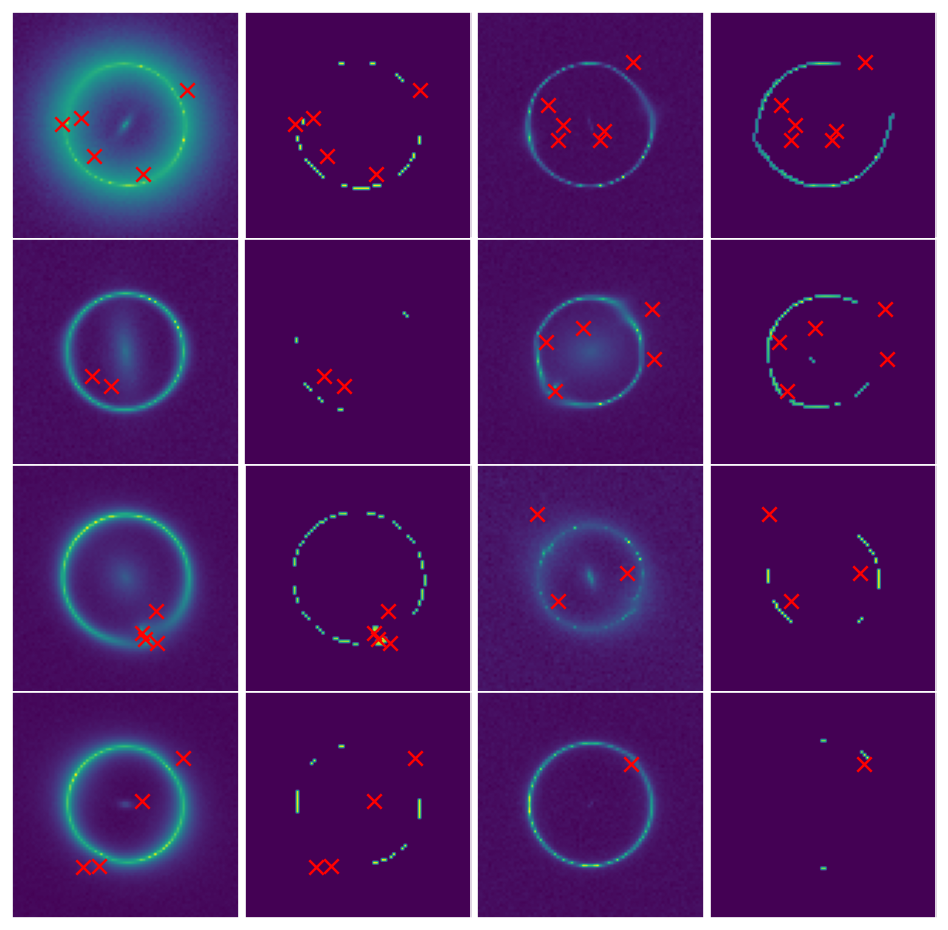

In [25]:
import numpy as np
full_true = tile_catalog["subhalos"].cpu().to_full_params()
main_deflector_true = tile_catalog["global"].cpu().to_full_params()

plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(4, 4, figsize=(10, 10), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)
for i, image_pair in enumerate(zip(images[:8], residuals[:8])):
    image, residual = image_pair
    offset = 16
    true_subhalo_pos = full_true.plocs[i,...].cpu().numpy()
    true_subhalo_pos = true_subhalo_pos[np.any(true_subhalo_pos, axis=1)] + offset

    total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = main_deflector_true["galaxy_params"][i,0]
    print(f"disk_frac={disk_frac}")
    
    pos = 2 * i
    axs[pos // 4, pos % 4].imshow(np.log(image[0].cpu().numpy() + 2))
    axs[(pos + 1) // 4, (pos + 1) % 4].imshow(np.log(residual[0].cpu().numpy() + 2))
    for j in [pos, pos + 1]:
        axs[j // 4, j % 4].set_xticklabels([])
        axs[j // 4, j % 4].set_yticklabels([])
        axs[j // 4, j % 4].tick_params(left = False, bottom = False)
        axs[j // 4, j % 4].scatter(true_subhalo_pos[:, 0], true_subhalo_pos[:, 1], marker='x', color='r', s=75)

In [26]:
galaxy_encoder = instantiate(cfg.models.galaxy_encoder).to(device).eval()
galaxy_encoder.load_state_dict(torch.load(cfg.plots.galaxy_checkpoint, map_location=galaxy_encoder.device))

lens_encoder = instantiate(cfg.models.lens_encoder).to(device).eval()
lens_encoder.load_state_dict(torch.load(cfg.plots.lens_checkpoint, map_location=lens_encoder.device))

decoder = instantiate(cfg.models.lens_decoder).to(device).eval()

In [27]:
from bliss.catalog import TileCatalog, get_images_in_tiles
from einops import rearrange

full_true = tile_catalog["global"].cpu().to_full_params()
image_ptiles = get_images_in_tiles(
    torch.cat((images, backgrounds), dim=1),
    80,
    80,
)
image_ptiles = rearrange(image_ptiles, "n nth ntw b h w -> (n nth ntw) b h w")
locs = rearrange(tile_catalog["global"].locs, "n nth ntw ns hw -> 1 (n nth ntw) ns hw")
galaxy_params = galaxy_encoder.sample(image_ptiles, locs, deterministic=True)
lens_params = lens_encoder.sample(image_ptiles, locs, deterministic=True)
main_deflector_locs = (torch.ones((1, 16, 1, 2)) * 40).to("cuda:0")

main_deflector_params = torch.cat((main_deflector_locs, galaxy_params, lens_params), dim=-1)
true_main_deflector_params = torch.cat((main_deflector_locs, full_true["galaxy_params"].to("cuda:0").unsqueeze(0), full_true["lens_params"].to("cuda:0").unsqueeze(0)), dim=-1)

dummy_subhalos = torch.zeros_like(main_deflector_params)

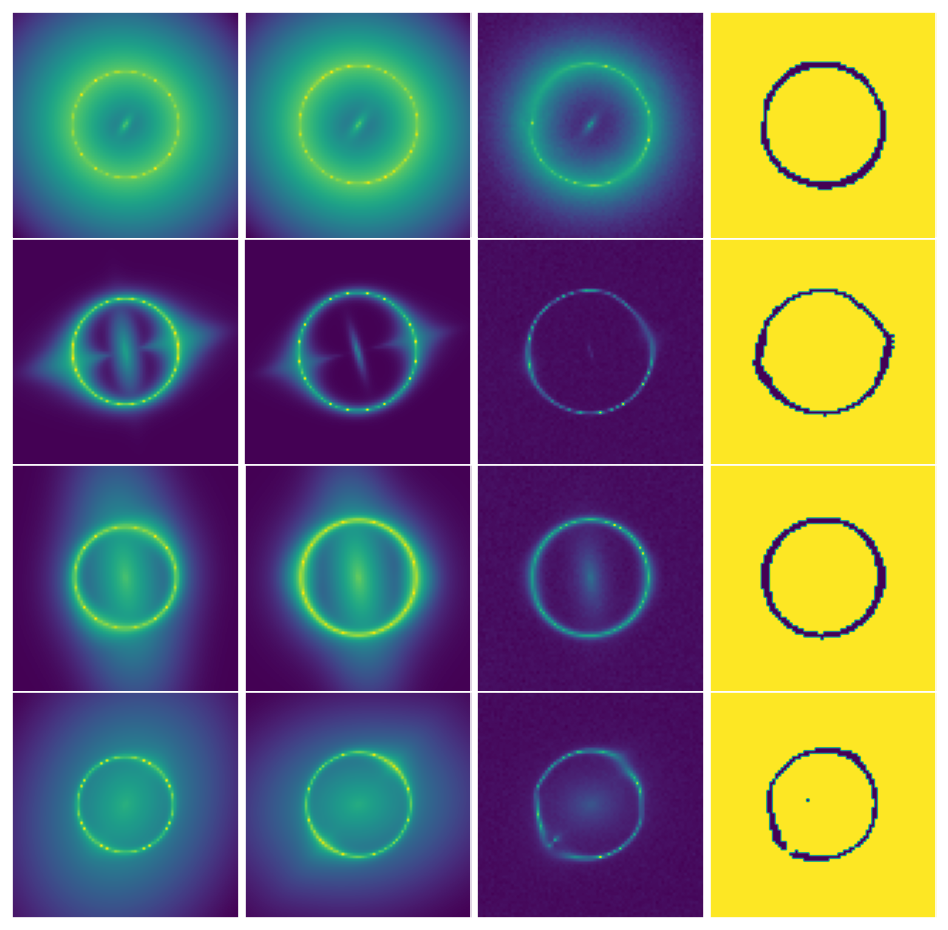

In [28]:
plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(4, 4, figsize=(10, 10), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)
for i, image_pair in enumerate(zip(images[:4], residuals[:4])):
    image, residual = image_pair
    image = image[0].cpu().numpy()
    offset = 16
    
    decoded_img_pred = decoder(main_deflector_params.detach()[:,i,...], dummy_subhalos.detach()[:,0,...], 80)["global"].cpu().numpy()[0,0,...]
    decoded_img_true = decoder(true_main_deflector_params.detach()[:,i,...], dummy_subhalos.detach()[:,0,...], 80)["global"].cpu().numpy()[0,0,...]

    thresholded_lensed_img = (image > np.quantile(image, 0.95)).astype(int)
    thresholded_main_lensed_img = (decoded_img_pred > np.quantile(decoded_img_pred, 0.95)).astype(int)
    residuals = ((thresholded_lensed_img - thresholded_main_lensed_img) == 1).astype(np.uint8) * 255

    pos = 4 * i
    axs[pos // 4, pos % 4].imshow(np.log(decoded_img_pred + 1))
    axs[(pos + 1) // 4, (pos + 1) % 4].imshow(np.log(decoded_img_true + 2))
    axs[(pos + 2) // 4, (pos + 2) % 4].imshow(np.log(image + 2))
    axs[(pos + 3) // 4, (pos + 3) % 4].imshow(np.log(residuals + 2))
    
    # axs[(pos + 1) // 4, (pos + 1) % 4].imshow(residuals)

    # print(f'predicted={lens_params[0,i,0]}')
    # print(f'true={full_true["lens_params"].to("cuda:0").unsqueeze(0)[0,i,0]}')
    # print("--------------------------------------------")

    for j in [pos, pos + 1, pos + 2, pos + 3]:
        axs[j // 4, j % 4].set_xticklabels([])
        axs[j // 4, j % 4].set_yticklabels([])
        axs[j // 4, j % 4].tick_params(left = False, bottom = False)